In [1]:
import sys
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import math

In [2]:
"""
Deterministic variant
Refer to https://www.aimath.org/WWN/populationmodel/chapmar25.pdf for theoretical basis
11/12/20
"""
def SIRDet(beta, gamma, mu, incubation, N, dt, I0, time, vac_start, vac_eff):
    #all given rates per day, dt as fraction of day, e.g. dt=1 is 1 day
    #beta = average number of infective contacts per person per day
    #gamma = recovery rate per day
    #mu = death rate per day
    t = np.arange(0,time,dt)
    n = len(t)
    alpha = 1/incubation
    S = np.zeros(n) #susceptible
    E = np.zeros(n) #exposed
    I = np.zeros(n) #infected
    R = np.zeros(n) #recovered
    D = np.zeros(n) #dead
    T = np.zeros(n) #total cases, includes infected, recovered and dead
    Q = np.zeros(n) #quarantined, not currently in use
    H = np.zeros(n) #hospitalised, not currently in use
    V = np.zeros(n) #vaccination
    V_s = np.zeros(n) #vaccinated gained immunity
    V_f = np.zeros(n) #vaccinated not gained immunity
    V_c = np.zeros(n) #cumulative vaccine
    
    S[0] = N - I0
    I[0] = I0
    T[0] = I[0]
    
    R0 = alpha*beta/((mu+alpha)*(mu+gamma)) #this needs reworking
    
    
    
    for i in range(1,n):
        
        if i >= (vac_start/dt):
            vac_rate = 0.25
        else:
            vac_rate = 0
    
        S[i] = (-beta*S[i-1]*(I[i-1]+E[i-1])/N - vac_rate*S[i-1])*dt + S[i-1] 
        E[i] = (beta*S[i-1]*(I[i-1]+E[i-1])/N + beta*V_f[i-1]*(I[i-1]+E[i-1])/N - alpha*E[i-1])*dt + E[i-1]
        I[i] = (alpha*E[i-1] - gamma*I[i-1] - mu*I[i-1])*dt + I[i-1]
        R[i] = (gamma*I[i-1])*dt + R[i-1]
        D[i] = (mu*I[i-1])*dt + D[i-1]
        V_s[i] = ((vac_eff/100)*vac_rate*S[i-1])*dt + V_s[i-1]
        V_f[i] = ((1-vac_eff/100)*vac_rate*S[i-1] - beta*V_f[i-1]*(I[i-1]+E[i-1])/N)*dt + V_f[i-1]
        V_c[i] = (vac_rate*S[i-1])*dt + V_c[i-1]
        T[i] = I[i] + R[i] + D[i]
    return{'t':t,'S':S,'E':E, 'I':I, 'R':R, 'D':D,\
           'Vaccinated':V_s, 'Cumulative Vaccinated': V_c,  'Total Cases':T,'Basic Reproduction Number':R0}

"""
Stochastic variant
Refer to https://www.aimath.org/WWN/populationmodel/chapmar25.pdf for theoretical basis
11/12/20
Add multinomial distribution for infected compartment
"""


def SIRSto(beta, gamma, mu, incubation, N, dt, I0, time, vac_start, vac_eff):
    #all given rates per day, time in days, dt as fraction of day, e.g. dt=1 is 1 day
    t = np.arange(0,time,dt)
    n = len(t)
    alpha = 1/incubation
    S = np.zeros(n) #susceptible
    E = np.zeros(n) #exposed
    I = np.zeros(n) #infected
    R = np.zeros(n) #recovered
    D = np.zeros(n) #dead
    T = np.zeros(n) #total cases
    Q = np.zeros(n) #quarantined, not in use in current model
    H = np.zeros(n) #hospitlaised,  not in use in current model
    V = np.zeros(n) #vaccination
    V_s = np.zeros(n) #vaccinated gained immunity
    V_f = np.zeros(n) #vaccinated not gained immunity
    V_c = np.zeros(n) #cumulative vaccine
    S[0] = N - I0
    I[0] = I0
    T[0] = I[0]
    
    R0 = alpha*beta/((mu+alpha)*(mu+gamma)) #this needs reworking
    
    
    for i in range(1,n):
        
        
        
        if i >= (vac_start/dt):
            vac_rate = 0.25
        else:
            vac_rate = 0
            
        leavingsus = np.random.multinomial(S[i-1], [1-np.exp((-beta*(I[i-1]+E[i-1])/N)*dt),\
        1-np.exp(-(vac_eff/100)*vac_rate*dt), 1-np.exp(-(1-vac_eff/100)*vac_rate*dt),\
        1-(1-np.exp((-beta*(I[i-1]+E[i-1])/N)*dt)+1-np.exp(-(vac_eff/100)*vac_rate*dt)+1-np.exp(-(1-vac_eff/100)*vac_rate*dt))])
        expnew = leavingsus[0]
        vacnew_s = leavingsus[1]
        vacnew_f = leavingsus[2]
        infnew = np.random.binomial(E[i-1],1-np.exp(-alpha*dt))
        leavinginf = np.random.multinomial(I[i-1], [1-np.exp(-gamma*dt), 1-np.exp(-mu*dt), \
        1-(1-np.exp(-gamma*dt)+1-np.exp(-mu*dt))])
        recnew = leavinginf[0]
        deadnew = leavinginf[1]
        vacexp = np.random.binomial(V_f[i-1], 1-np.exp((-beta*(I[i-1]+E[i-1])/N)*dt))
        S[i] = S[i-1] - expnew - vacnew_s - vacnew_f
        E[i] = E[i-1] + expnew - infnew + vacexp
        I[i] = I[i-1] + infnew - recnew - deadnew
        R[i] = R[i-1] + recnew
        D[i] = D[i-1] + deadnew
        V_s[i] = V_s[i-1] + vacnew_s
        V_f[i] = V_f[i-1] + vacnew_f - vacexp
        V_c[i] = V_c[i-1] + vacnew_s + vacnew_f
        T[i] = I[i] + R[i] + D[i]
    return{'t':t,'S':S,'E':E, 'I':I, 'R':R, 'D':D,\
           'Vaccinated':V_s, 'Cumulative Vaccinated': V_c, 'Total Cases':T,'Basic Reproduction Number':R0}

In [3]:
sir_out = pd.DataFrame(SIRSto(0.25, 0.1, 0.01, 5, 100000, 0.1, 1, 300, 50, 70))
sir_out_det = pd.DataFrame(SIRDet(0.25, 0.1, 0.01, 5, 100000, 0.1, 1, 300, 25, 70))

In [4]:
pd.set_option('display.max_rows', None)
sir_out_det

,t,S,E,I,R,D,Vaccinated,Cumulative Vaccinated,Total Cases,Basic Reproduction Number
0,0.0,9.999900e+04,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2.164502
1,0.1,9.999898e+04,0.025000,0.989000,0.010000,0.001000,0.000000,0.000000,1.000000,2.164502
2,0.2,9.999895e+04,0.049849,0.978621,0.019890,0.001989,0.000000,0.000000,1.000500,2.164502
3,0.3,9.999892e+04,0.074564,0.968853,0.029676,0.002968,0.000000,0.000000,1.001497,2.164502
4,0.4,9.999890e+04,0.099158,0.959687,0.039365,0.003936,0.000000,0.000000,1.002988,2.164502
5,0.5,9.999887e+04,0.123646,0.951114,0.048962,0.004896,0.000000,0.000000,1.004971,2.164502
6,0.6,9.999884e+04,0.148041,0.943124,0.058473,0.005847,0.000000,0.000000,1.007444,2.164502
7,0.7,9.999882e+04,0.172359,0.935711,0.067904,0.006790,0.000000,0.000000,1.010405,2.164502
8,0.8,9.999879e+04,0.196614,0.928865,0.077261,0.007726,0.000000,0.000000,1.013852,2.164502
9,0.9,9.999876e+04,0.220818,0.922580,0.086550,0.008655,0.000000,0.000000,1.017785,2.164502


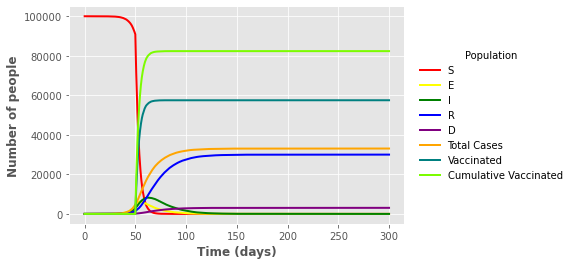

In [145]:
#stochastic
plt.style.use("ggplot")
sline = plt.plot("t","S","",data=sir_out,color="red",linewidth=2)
eline = plt.plot("t","E","",data=sir_out,color="yellow",linewidth=2)
iline = plt.plot("t","I","",data=sir_out,color="green",linewidth=2)
rline = plt.plot("t","R","",data=sir_out,color="blue",linewidth=2)
dline = plt.plot("t","D","",data=sir_out,color="purple",linewidth=2)
tline = plt.plot("t","Total Cases","",data=sir_out,color="orange",linewidth=2)
vline = plt.plot("t","Vaccinated","",data=sir_out,color="teal",linewidth=2)
vcline = plt.plot("t","Cumulative Vaccinated","",data=sir_out,color="lawngreen",linewidth=2)
plt.xlabel("Time (days)",fontweight="bold")
plt.ylabel("Number of people",fontweight="bold")
legend = plt.legend(title="Population",loc=5,bbox_to_anchor=(1.50,0.5))
frame = legend.get_frame()
frame.set_facecolor("white")
frame.set_linewidth(0)

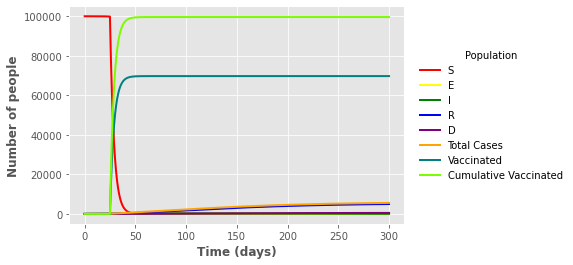

In [104]:
#deterministic
plt.style.use("ggplot")
sline = plt.plot("t","S","",data=sir_out_det,color="red",linewidth=2)
eline = plt.plot("t","E","",data=sir_out_det,color="yellow",linewidth=2)
iline = plt.plot("t","I","",data=sir_out_det,color="green",linewidth=2)
rline = plt.plot("t","R","",data=sir_out_det,color="blue",linewidth=2)
dline = plt.plot("t","D","",data=sir_out_det,color="purple",linewidth=2)
tline = plt.plot("t","Total Cases","",data=sir_out_det,color="orange",linewidth=2)
vline = plt.plot("t","Vaccinated","",data=sir_out_det,color="teal",linewidth=2)
vcline = plt.plot("t","Cumulative Vaccinated","",data=sir_out_det,color="lawngreen",linewidth=2)

plt.xlabel("Time (days)",fontweight="bold")
plt.ylabel("Number of people",fontweight="bold")
legend = plt.legend(title="Population",loc=5,bbox_to_anchor=(1.50,0.5))
frame = legend.get_frame()
frame.set_facecolor("white")
frame.set_linewidth(0)

In [ ]:
for i in range(0,100):
    sir_out = pd.DataFrame(SIRSto(0.25, 0.1, 0.01, 5, 100000, 0.1, 1, 300, 50, 70))
    plt.style.use("ggplot")
    line = plt.plot("t","V","",data=sir_out,color="purple",linewidth=0.5)
    plt.xlabel("Time",fontweight="bold")
    plt.ylabel("Number",fontweight="bold")
    

linedet = plt.plot("t","V","",data=sir_out_det,color="black",linewidth=2)

In [30]:
# finds actual effectiveness of vaccine over 100 stochastic trials
#filters out effectivenesses of 100% as these occur when no outbreak has happened mathematically
#potentially skewed by very minor outbreaks meaning less vaccinated people come into contact with infected people
Actual_eff = []
for i in range(0,100):
    sir_out = pd.DataFrame(SIRSto(0.25, 0.1, 0.01, 5, 100000, 0.1, 1, 300, 50, 82))
    v_max = (np.max(sir_out["V_c"]))
    v_fin = sir_out["V"].iloc[-1]
    Actual_eff.append((v_fin/v_max)*100)
    
    
F_Actual_eff = []
for i in range(0, len(Actual_eff)):
    if Actual_eff[i] != 100.0:
        F_Actual_eff.append(Actual_eff[i])

np.average(F_Actual_eff)

81.88474970114618

In [17]:
#finds actual effectiveness of vaccine in deterministic model
sir_out_det = pd.DataFrame(SIRDet(0.25, 0.1, 0.01, 5, 100000, 0.1, 1, 300, 50, 70))
v_max = (np.max(sir_out_det["V_c"]))
v_fin = sir_out_det["V"].iloc[-1]
print((v_fin/v_max)*100)

69.9999999999997
